In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

# Intro to the NN API

Tensorflow has a nice api that includes many functions that we can help to seamlessly build and train neural networks models. End-to-end, the components we need to build are:
 * NN model --  takes inputs and makes a prediction
 * loss function -- takes NN model predictions and labels and calculates loss
 * optimizer -- calculates gradients of loss w.r.t. model parameters and sets update rules
 * training loop -- cycle through data with mini-batches and update parameters
 
Let's first discuss the first part, building the NN model.  

## Intro to MLP

The multi-layer perceptron model is the standard neural network that first comes to mind when mentioning artificial neural networks.  It is a feed-forward neural network that takes as input a vector of input features, the has one or more hidden layers, with the number of neurons set by your heart's desire, followed by an output layer to make a prediction. If we are doing a simple linear regression, we just need one output neuron.  If we are classifying 10 different objects for a computer vision task, then we need 10 output neurons.  

Each hidden layer consist of a fully-connected layer, also known as a dense layer, that takes each of its inputs and calculates a weighted-sum to each hidden neuron.  Importantly, the weighted sum is then processed with a non-linear activation.  It turns out, theoretically, what this non-linear activation doesn't matter much. In practice, however, certain non-linear activations, like the rectified linear unit (ReLU), are easier to work with, making it easier to train deep neural networks. 

The MLP architecture has been well-characterized in terms of its expressive power and approximation capabilities.  Given enough hidden units, this kind of network can be considered a universal function approximator mapping the relationship between the input and the outputs.  

Let's build some basic components of a MLP!

Suppose we have 4 different mutations and we have some experimentally-determined fitness value. One thing we can do with thid data is to see if a MLP can learn the relationship between fitness and the combination of mutations. This data is taken directly from:

Wu et. al. "Adaptation in protein fitness landscapes is facilitated by indirect paths" eLife, 2016.

### load fitness data and training labels

load the data from the supplemental file.  Convert the 4 mutations into a one-hot representation and normalize the fitness scores to a z-score.

In [2]:
# load dataset
filename = '../data/elife-16965-supp1-v4.xlsx'
df = pd.read_excel(filename)

# parse variants and fitness
variants = df['Variants'].as_matrix()
fitness = df['Fitness'].as_matrix()

# filter data with a fitness of 0
index = np.where(fitness!=0)[0]
variants = variants[index]
fitness = fitness[index]

# create a one-hot vector for each variant
alphabet = 'ACEDGFIHKMLNQPSRTWVY'
num_alphabet = len(alphabet)
num_variants = len(variants)
one_hot = np.zeros((num_variants, num_alphabet, 4))
for i in range(num_variants):
    seq = str(variants[i])
    for j in range(len(seq)):
        index = alphabet.index(seq[j])
        one_hot[i,index,j] = 1
        
# normalize fitness
mu = np.mean(fitness)
sigma = np.std(fitness)
fitness = (fitness-mu)/sigma

# convert to float 32 for GPU analysis
one_hot = one_hot.astype(np.float32)
fitness = fitness.astype(np.float32)

#### Split dataset into a training set, validation set, and test set

In [3]:
np.random.seed(247) # for reproducibility

# split dataset into training cross validation and testing
train_size = 0.65
valid_size = 0.1
test_size = 0.25
split_size = [train_size, valid_size, test_size]

# generate a shuffled subset of data for train, validation, and test
num_seq = len(fitness)
cum_index = np.cumsum(np.multiply([0, split_size[0], split_size[1], split_size[2]], num_seq)).astype(int) 

# randomly shuffle dataset
shuffle = np.random.permutation(num_seq)

# get shuffled indices for each data set
train_index = shuffle[range(cum_index[0], cum_index[1])]
valid_index = shuffle[range(cum_index[1], cum_index[2])]
test_index = shuffle[range(cum_index[2], cum_index[3])]

# create subsets of data based on indices 
X_train = one_hot[train_index]
Y_train = np.expand_dims(fitness[train_index], axis=1)
X_valid = one_hot[valid_index]
Y_valid = np.expand_dims(fitness[valid_index], axis=1)
X_test = one_hot[test_index]
Y_test = np.expand_dims(fitness[test_index], axis=1)

# build MLP model

### Input layer

Next, we need to establish placeholders to be able to feed in input features into the MLP model. Since the data has an ndarray shape of 3, due to the one-hot representation, we need to flatten it such that it is a vector.  We can do this as a preprocessing step in numpy or we can include this reshape within the tensorflow graph.  

In [4]:
tf.reset_default_graph()

# placeholder
inputs = tf.placeholder(tf.float32, shape=[None, num_alphabet, 4])

# reshape the inputs to be flat
input_layer = tf.reshape(inputs, [-1, 4*num_alphabet])

Here x and y_ aren't specific values. Rather, they are each a placeholder -- a value that we'll input when we ask TensorFlow to run a computation. shape=None means that tensors of any shape will be accepted. Using shape=None is easy to construct graphs, but nightmarish for debugging. You should always define the shape of your placeholders as detailed as possible. 


### Weight Initialization

To create this model, we're going to need to create a lot of weights and biases. One should generally initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients. Since we're using ReLU neurons, it is also good practice to initialize them with a slightly positive initial bias to avoid "dead neurons". Instead of doing this repeatedly while we build the model, let's create two handy functions to do it for us.

In this most common case, the weights are initialized with the tf.truncated_normal and given their shape of a 2-D tensor with the first dim representing the number of units in the layer from which the weights connect and the second dim representing the number of units in the layer to which the weights connect. For the first layer, named hidden1, the dimensions are [IMAGE_PIXELS, hidden1_units] because the weights are connecting the image inputs to the hidden1 layer. The tf.truncated_normal initializer generates a random distribution with a given mean and standard deviation.

Then the biases are initialized with tf.zeros to ensure they start with all zero values, and their shape is simply the number of units in the layer to which they connect.

The graph's three primary ops -- two tf.nn.relu ops wrapping tf.matmul for the hidden layers and one extra tf.matmul for the logits -- are then created, each in turn, with separate tf.Variable instances connected to each of the input placeholders or the output tensors of the previous layer.


  Now, we are going to be instantiating tensorflow variables.  To do so, we need to initialize them.  A standard initialization used for neural networks is He-inits and Glorot-inits.  Here, we will use he inits.  Let's define a function for He-inits for the parameters and constant-inits for the bias terms.

In [6]:
# functions for initializations also known as inits
def he_init(shape):
    """He inits are designed for neural networks that employ ReLU activations."""
    # fan_in is the number of neurons going into the layer
    stddev = np.sqrt(2.6/shape[0])
    return tf.truncated_normal(shape=shape, mean=0.0, stddev=stddev, dtype=tf.float32)

def const_init(shape, value=0.0):
    """constant inits are useful for bias terms"""
    return tf.constant(shape=shape, value=value, dtype=tf.float32)

### Dense layer

For more details:
https://cs231n.github.io/convolutional-networks/


To help improve the results of our model, we also apply dropout regularization to our dense layer, using the dropout method in layers:

dropout = tf.layers.dropout(
    inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
Again, inputs specifies the input tensor, which is the output tensor from our dense layer (dense).

The rate argument specifies the dropout rate; here, we use 0.4, which means 40% of the elements will be randomly dropped out during training.

The training argument takes a boolean specifying whether or not the model is currently being run in training mode; dropout will only be performed if training is True. Here, we check if the mode passed to our model function cnn_model_fn is TRAIN mode.

In [7]:

# build a fully-connected layer (also known as a dense layer)
num_units = 256
num_incoming = 4*num_alphabet
W1 = tf.Variable(he_init(shape=[num_incoming, num_units]), name='W1')
b1 = tf.Variable(const_init(shape=[num_units], value=0.01), name='b1')
dense_1 = tf.matmul(input_layer, W1)

# add bias term
dense_1_bias = tf.nn.bias_add(dense_1, b1)

# perform activation
dense_1_active = tf.nn.relu(dense_1_bias)

### Dropout

To reduce overfitting, we will apply dropout before the readout layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.1

In [8]:
# create placeholder for dropout keep probability
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# apply dropout to dense 1 layer
dense_1_dropout = tf.nn.dropout(dense_1_active, keep_prob=keep_prob)

### fully-connected output layer

The output layer is a linear regression model.  

In [9]:
# create variable for weights and biases
W2 = tf.Variable(he_init(shape=[num_units, 1]), name='W2')
b2 = tf.Variable(const_init(shape=[1], value=0.01), name='b2')

# build a fully-connected layer (also known as a dense layer)
dense_2 = tf.matmul(dense_1_dropout, W2)

# add bias term
predictions = tf.nn.bias_add(dense_2, b2)

### Calculate Loss

For both training and evaluation, we need to define a loss function that measures how closely the model's predictions match the target classes. This is usually a log-likelihood function for supervised learning.  The log-likelihood for a linear regression is a mean-squared error, with some basic assumptions of course.  

We also need to be able to calculate the gradients of the loss function with respect to the parameters of the model, which is efficiently accomplished with backpropagation.  Then, we can update the weights with a scaled gradients, which is knownas gradient descent learning. 

Fortunately, tensorflow provides a nice wrappers to perform all of this with the tf.train API.  Within tf.train are numerous types of gradient descent optimizers, including traditional stochastic gradient descent (SGD), SGD with momentum, ADAGRAD, RMSPROP, ADAM, plus more.  We will use ADAM in this notebook.  

In [10]:
# instantiate placeholder for labels 
targets = tf.placeholder(tf.float32, shape=[None, 1], name='targets')

# calculate binary cross-entropy loss function
squared_error = tf.square(predictions - targets)
loss_function = tf.reduce_mean(squared_error)
    
# get a list of all trainable variables
trainable_vars = tf.trainable_variables()

# flatten and concatenate all parameters for L2/L1 regularization
all_params = []
for param in trainable_vars:
    all_params = tf.concat([all_params, tf.reshape(param, [-1,])], axis=0)
    
# calculate L2 regularization
l2_strength = 1e-5
loss_function += tf.reduce_sum(tf.square(all_params))*l2_strength

# setup optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0003, 
                                   beta1=0.9, 
                                   beta2=0.999)
update_vars = optimizer.minimize(loss_function, var_list=trainable_vars)

# Train the MLP

### Create a session

In [11]:
# create session
sess = tf.Session()

# initialize all variables
sess.run(tf.global_variables_initializer())



### batch iterator

We want to train our CNN model with mini-batch stochastic gradient descent.  So, we need a way to generate mini-batches of data. An effective strategy for training is to shuffle the dataset between each epoch. So, let's define a function to generate shuffled mini-batches. 

In [12]:
def batch_generator(X, y, batch_size=128, shuffle=True):
    """function to generate mini-batches of the data"""
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32), y[excerpt].astype(np.float32)

### train MLP

In [13]:
# path to save model parameters
save_path = '../results/epistasis'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
    print("making directory: " + save_path)
params_path = os.path.join(save_path, 'mlp')
    
    
num_epochs = 50        # maximum number of epochs
batch_size = 100         # mini-batch size for a parameter update
patience = 10         # number of epochs to wait for a lower validation loss to be found. 
num_train_batches = X_train.shape[0] // batch_size

# training loop
wait = 0
min_loss = 1e10
for epoch in range(num_epochs):

    # make a batch ganerator for the training data
    train_batches = batch_generator(X_train, Y_train, batch_size, shuffle=True)

    # loop over training batches
    train_loss = 0
    for index in range(num_train_batches):
        # get a mini-batch
        x_batch, y_batch = next(train_batches)
        
        # update over a mini-batch
        loss, _ = sess.run([loss_function, update_vars], 
                           feed_dict={inputs: x_batch, 
                                      targets: y_batch, 
                                      keep_prob: 0.5}
                          )
        train_loss += loss
        
    # check progress on validation set
    valid_loss, valid_predict = sess.run([loss_function, predictions], 
                                         feed_dict={inputs: X_valid, 
                                                    targets: Y_valid, 
                                                    keep_prob: 1.0}
                                        )

    # calculate performance metrics
    pearsonr = np.corrcoef(Y_valid[:,0], valid_predict[:,0])[0][1]

    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))
    print("  validation loss:\t\t{:.6f}".format(valid_loss))
    print("  validation Pearson r:\t\t{:.6f}".format(pearsonr))
    
    
    # check if current validation loss is lower, if so, save parameters, if not check patience
    if valid_loss < min_loss:
        print("  Lower validation loss found. Saving parameters to: "+params_path)
        
        # save model parameters
        saver = tf.train.Saver()
        saver.save(sess, save_path=params_path)
        
        # set minimum loss to the current validation loss
        min_loss = valid_loss
        
        # reset wait time
        wait = 0
    else:
        
        # add to wait time
        wait += 1
        
        # check to see if patience has run out
        if wait == patience:
            print("Patience ran out... early stopping!")
            break

making directory: ../results/epistasis
Epoch 1 of 50
  training loss:		0.905065
  validation loss:		0.662489
  validation Pearson r:		0.509828
  Lower validation loss found. Saving parameters to: ../results/epistasis/mlp
Epoch 2 of 50
  training loss:		0.744407
  validation loss:		0.570326
  validation Pearson r:		0.606186
  Lower validation loss found. Saving parameters to: ../results/epistasis/mlp
Epoch 3 of 50
  training loss:		0.623410
  validation loss:		0.471984
  validation Pearson r:		0.692996
  Lower validation loss found. Saving parameters to: ../results/epistasis/mlp
Epoch 4 of 50
  training loss:		0.516946
  validation loss:		0.398697
  validation Pearson r:		0.747844
  Lower validation loss found. Saving parameters to: ../results/epistasis/mlp
Epoch 5 of 50
  training loss:		0.440017
  validation loss:		0.347614
  validation Pearson r:		0.785984
  Lower validation loss found. Saving parameters to: ../results/epistasis/mlp
Epoch 6 of 50
  training loss:		0.382777
  validati

Epoch 47 of 50
  training loss:		0.108724
  validation loss:		0.085820
  validation Pearson r:		0.952241
  Lower validation loss found. Saving parameters to: ../results/epistasis/mlp
Epoch 48 of 50
  training loss:		0.110836
  validation loss:		0.085244
  validation Pearson r:		0.951851
  Lower validation loss found. Saving parameters to: ../results/epistasis/mlp
Epoch 49 of 50
  training loss:		0.110364
  validation loss:		0.084088
  validation Pearson r:		0.952664
  Lower validation loss found. Saving parameters to: ../results/epistasis/mlp
Epoch 50 of 50
  training loss:		0.110257
  validation loss:		0.083850
  validation Pearson r:		0.953591
  Lower validation loss found. Saving parameters to: ../results/epistasis/mlp


####  let's close the session, so we can walk through an example of how to load the parameters

In [14]:
# close tensorflow session (Note, the graph is still open)
sess.close()

# we can restore the parameters to our graph

In [16]:
# create a new session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# path to save results
save_path = '../results/epistasis'
params_path = os.path.join(save_path, 'mlp')

# restore trained parameters
saver = tf.train.Saver()
saver.restore(sess, save_path=params_path)

INFO:tensorflow:Restoring parameters from ../results/epistasis/mlp


# Now let's test our trained model

In [17]:
# test model
test_loss, test_predict = sess.run([loss_function, predictions], 
                                     feed_dict={inputs: X_test, 
                                                targets: Y_test, 
                                                keep_prob: 1.0})

# calculate performance metrics
pearsonr = np.corrcoef(Y_test[:,0], test_predict[:,0])[0][1]


print("  validation loss:\t\t{:.6f}".format(test_loss))
print("  validation Pearson r:\t\t{:.6f}".format(pearsonr))

  validation loss:		0.079236
  validation Pearson r:		0.963289


# scatter plot of prediction and experimental values

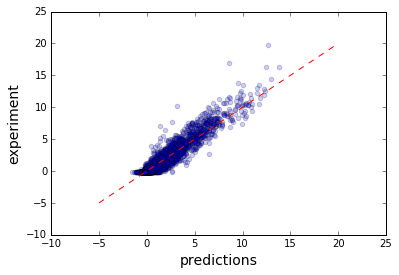

In [18]:
plt.figure()
plt.scatter(test_predict[:,0], Y_test[:,0], alpha=0.2)
plt.xlabel('predictions', fontsize=14)
plt.ylabel('experiment', fontsize=14)
plt.plot([-5,20],[-5,20],'--r')

# Let's generate a saliency map

To calculate a saliency map, we need to calculate the derivative of the output neuron with respect to the inputs.  Luckily, tensorflow makes this easy because it calculates gradients using automatic differentiation.  We can calculate the gradient with the function tf.gradients.  This method constructs partial derivatives of ys w.r.t. x in xs. ys and xs are each a Tensor or a list of tensors. 

tf.gradients(
    ys,
    xs,
    grad_ys=None,
    name='gradients',
    colocate_gradients_with_ops=False,
    gate_gradients=False,
    aggregation_method=None,
    stop_gradients=None
)

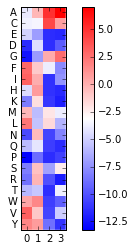

In [33]:
# let's get the highest predicted sequence 
max_index = np.argsort(test_predict[:,0])[::-1]

# get sequence
index = 2
X = np.expand_dims(X_test[max_index[index]], axis=0)

# calculate the gradients to the inputs
grad_to_inputs = tf.gradients(predictions, inputs)

# run the session to calculate the saliency map for a given sequence X
backprop_saliency = sess.run(grad_to_inputs, feed_dict={inputs: X, 
                                                        keep_prob: 1.0})


# plot a heat map of the saliency values (each row is a different amino acid from the one-hot definition)
plt.figure()
plt.imshow(backprop_saliency[0][0], interpolation='None', cmap='bwr')
plt.colorbar()
plt.yticks(range(20), alphabet)
plt.xticks(range(4));

# Where to go from here

###  official tutorials

https://www.tensorflow.org/tutorials/


### lower-level APIs

https://www.tensorflow.org/api_docs/python/tf/nn


### Layers 
    
https://www.tensorflow.org/api_docs/python/tf/layers
  
* tf.nn.layers.conv2d()
* tf.nn.layers.dense
* tf.nn.layers.dropout
* tf.nn.layers.max_pooling2d
* tf.nn.layers.batch_normalization


### alternative 

* tf.contrib.layers
* tf.keras.layers